In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import RobertaTokenizer
import numpy as np
from transformers import TFRobertaForSequenceClassification, RobertaConfig
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
from tensorflow.keras.callbacks import ModelCheckpoint

2024-04-02 09:48:13.543500: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 09:48:13.543553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 09:48:13.544755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 09:48:13.551251: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
EPOCHS = 30
TEST_SIZE = 0.2
RANDOM_STATE = 42
MAX_LEN = 128  # Maximum sequence length
NUM_LABELS = 2

# Define the base path for saving model information
base_save_path = "Roberta-difference-anger-disgust_checkpoints"
checkpoint_path = "Roberta-difference-anger-disgust_checkpoints/cp-{epoch:04d}.ckpt"

In [3]:
def f1_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
# Specify the path to your CSV file
file_path = 'surprise_happiness_sentences.csv'

# Load the dataset
dataset = pd.read_csv(file_path)

data = dataset.drop_duplicates()

# Shuffle the combined dataset
data = data.sample(frac=1).reset_index(drop=True)

# Display basic information about the combined dataset
print("Preview of the dataset:")
print(data.head())

print("\nSummary statistics of the  dataset:")
print(data.describe())

print("\nInformation about columns in the dataset:")
print(data.info())

sentences = data['sentence'].values
labels = data['emotion'].values

Preview of the dataset:
                                            sentence    emotion
0  for about one year i had a rather bad relation...  happiness
1  i do see myself as unlovable from a romatic lo...  happiness
2  The last thing a stray dog expected on reveal ...   surprise
3  In the middle of the CEO, embark on a remarkab...   surprise
4  Against all odds, the mysterious box managed t...   surprise

Summary statistics of the  dataset:
                                                 sentence    emotion
count                                              245558     245558
unique                                             245558          2
top     for about one year i had a rather bad relation...  happiness
freq                                                    1     190250

Information about columns in the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245558 entries, 0 to 245557
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    ---

In [5]:
# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels = tf.convert_to_tensor(labels)

2024-04-02 09:48:18.149923: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-04-02 09:48:18.150270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16248 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


In [6]:
# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize sentences to get input IDs and attention masks
max_len = 128  # or choose a different max length
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens=True,
                        max_length=max_len,
                        truncation=True,
                        padding='max_length',
                        return_attention_mask=True,
                        return_tensors='tf',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert lists to tensors
input_ids = tf.concat(input_ids, axis=0)
attention_masks = tf.concat(attention_masks, axis=0)

In [7]:
# Ensure all inputs to train_test_split are numpy arrays
input_ids_np = input_ids.numpy() if isinstance(input_ids, tf.Tensor) else input_ids
attention_masks_np = attention_masks.numpy() if isinstance(attention_masks, tf.Tensor) else attention_masks
labels_np = labels.numpy() if isinstance(labels, tf.Tensor) else labels

# Now perform the train-test split
X_train, X_val, y_train, y_val = train_test_split(input_ids_np, labels_np, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=labels_np)
train_mask, val_mask = train_test_split(attention_masks_np, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=labels_np)

# Convert numpy arrays back to tensors for TensorFlow compatibility
X_train = tf.constant(X_train)
X_val = tf.constant(X_val)
y_train = tf.constant(y_train)
y_val = tf.constant(y_val)
train_mask = tf.constant(train_mask)
val_mask = tf.constant(val_mask)

In [8]:
# Create TensorFlow datasets for the training and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": X_train, "attention_mask": train_mask}, y_train)).shuffle(len(X_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": X_val, "attention_mask": val_mask}, y_val)).batch(BATCH_SIZE)

In [9]:
# Load RoBERTa model
model_config = RobertaConfig.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', config=model_config)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', f1_metric])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation accuracy
    patience=2,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,              # Log when training is stopped
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
    mode='min'
)

In [11]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,  # Reduction factor for the learning rate
    patience=1,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1
)

In [12]:
# Fit label encoder and return encoded labels
labels_encoded = label_encoder.fit_transform(labels)

In [13]:
# Count the number of occurrences of each class
class_counts = np.unique(labels_encoded, return_counts=True)[1]

# Calculate total number of samples
total_samples = len(labels_encoded)

# Calculate class weights inversely proportional to the class frequencies
class_weights = {i: total_samples/(count * len(class_counts)) for i, count in enumerate(class_counts)}

In [14]:
# Specify the directory where you want to save the checkpoints
checkpoint_dir = os.path.dirname(checkpoint_path)

# Ensure the directory exists. If it doesn't, create it.
os.makedirs(base_save_path, exist_ok=True)

# Specify the checkpoint file path pattern
checkpoint_path = os.path.join(base_save_path, "cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a ModelCheckpoint callback
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True, 
    save_best_only=True,  # Saves only the best model
    monitor='val_loss',  # Monitoring validation loss to determine the best model
    mode='min',  # Since we're monitoring 'val_loss', 'min' mode saves the model when the metric has decreased
    save_freq='epoch')  # Saving the model after each epoch

In [15]:
# Fit the model with class weights, early stopping, and learning rate scheduler
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, lr_scheduler, cp_callback],
    class_weight=class_weights  # Use the calculated class weights
)


Epoch 1/30


2024-04-02 09:50:52.603610: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f17dc2cdfa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-02 09:50:52.603660: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-04-02 09:50:52.612936: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-02 09:50:52.648724: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1712051452.747824 1723209 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3070/3070 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9798 - f1_metric: 0.3614
Epoch 1: val_loss improved from inf to 0.03244, saving model to Roberta-difference-anger-disgust_checkpoints/cp-0001.ckpt
3070/3070 [==============================] - 3242s 1s/step - loss: 0.0528 - accuracy: 0.9798 - f1_metric: 0.3614 - val_loss: 0.0324 - val_accuracy: 0.9881 - val_f1_metric: 0.3636 - lr: 1.0000e-05
Epoch 2/30
3070/3070 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.9897 - f1_metric: 0.3633
Epoch 2: val_loss improved from 0.03244 to 0.02303, saving model to Roberta-difference-anger-disgust_checkpoints/cp-0002.ckpt
3070/3070 [==============================] - 1371s 447ms/step - loss: 0.0262 - accuracy: 0.9897 - f1_metric: 0.3633 - val_loss: 0.0230 - val_accuracy: 0.9912 - val_f1_metric: 0.3634 - lr: 1.0000e-05
Epoch 3/30
3070/3070 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9920 - f1_metric: 0.3638
Epoch 3: Reduc

1535/1535 [==============================] - 156s 100ms/step


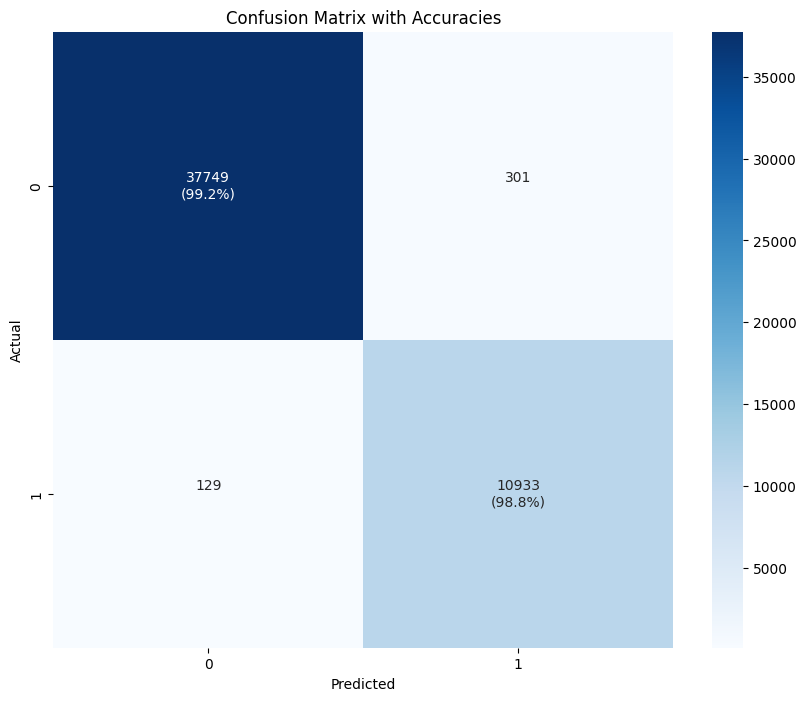

In [16]:
# Assuming X_val and y_val are your test inputs and labels, respectively.
# If you have a separate test set, replace X_val and y_val accordingly.

# Predict classes with the model
predictions = model.predict({"input_ids": X_val, "attention_mask": val_mask})
predicted_labels = np.argmax(predictions.logits, axis=1)

# Since your labels are already encoded with LabelEncoder, there's no need to decode them

# Generate the confusion matrix
cm = confusion_matrix(y_val, predicted_labels)

# Calculate per-class accuracies
accuracies = cm.diagonal() / cm.sum(axis=1)

# Create an annotated confusion matrix with accuracies
cm_with_acc = cm.astype('str')  # Convert counts to string for annotation
for i in range(len(cm)):
    for j in range(len(cm[i])):
        # Append accuracy to the diagonal elements
        if i == j:
            cm_with_acc[i][j] = f"{cm[i][j]}\n({accuracies[i]*100:.1f}%)"
        else:
            cm_with_acc[i][j] += "\n "

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=cm_with_acc, fmt='', ax=ax, cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix with Accuracies')
plt.show()
